In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Last Date in DB: 2017-08-23

One year ago: 2016-08-23 

SELECT measurement.date, measurement.prcp 
FROM measurement 
WHERE measurement.date >= :date_1 ORDER BY measurement.date
 
            prcp
date            
2016-08-23  0.00
2016-08-23  0.15
2016-08-23  0.05
2016-08-23   NaN
2016-08-23  0.02


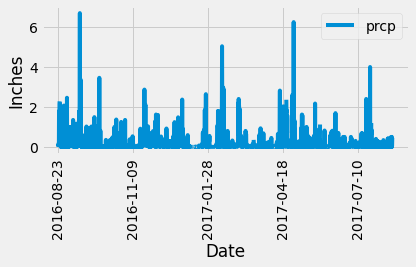

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_data_point = session.query(func.max(Measurement.date)).first()[0]

year = int(last_data_point.split('-')[0])
mth = int(last_data_point.split('-')[1])
date = int(last_data_point.split('-')[2])

last_date_in_db = dt.date(year, mth, date)
print("Last Date in DB:", last_date_in_db)

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = last_date_in_db - dt.timedelta(days=365)
print("\nOne year ago:", one_year_ago,"\n")

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp)\
                    .filter(Measurement.date >= one_year_ago)\
                    .order_by(Measurement.date).statement
print(query)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(query, session.bind)
new_df = df.set_index(df.date)
new_df = new_df[["prcp"]]
print(" ")
print(new_df.head())

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
new_df.plot(rot=90)

#Set the x and y axis labels
plt.xlabel("Date")
plt.ylabel("Inches")

# Save and display the plot
plt.tight_layout()
plt.savefig("Images/precipitation.png")
plt.show()

In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
new_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [27]:
# Design a query to show how many stations are available in this dataset?
station_cnt = session.query(func.distinct(Measurement.station)).count()
print(station_cnt)

9


In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations_query = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .statement
print(active_stations_query)

active_stations_df = pd.read_sql_query(active_stations_query, session.bind)
active_stations_df

SELECT measurement.station, count(measurement.station) AS count_1 
FROM measurement GROUP BY measurement.station ORDER BY count(measurement.station) DESC


,station,count_1
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [29]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_stations = session.query(func.min(Measurement.tobs),
                              func.max(Measurement.tobs),
                              func.avg(Measurement.tobs))\
                            .filter(Measurement.station == 'USC00519281')\
                            .all()
print("Lowest Temperature Recorded in Station ID - USC00519281:", temp_stations[0][0])
print("Highest Temperature Recorded in Station ID - USC00519281:", temp_stations[0][1])
print("Average Temperature Recorded in Station ID - USC00519281:", temp_stations[0][2])

Lowest Temperature Recorded in Station ID - USC00519281: 54.0
Highest Temperature Recorded in Station ID - USC00519281: 85.0
Average Temperature Recorded in Station ID - USC00519281: 71.66378066378067


In [31]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_mths_tobs_query = session.query(Measurement.tobs)\
                            .filter(Measurement.station == 'USC00519281')\
                            .filter(Measurement.date >= one_year_ago)\
                            .statement
print(last_12_mths_tobs_query)

last_12_mths_tobs_df = pd.read_sql_query(last_12_mths_tobs_query, session.bind)
last_12_mths_tobs_df

SELECT measurement.tobs 
FROM measurement 
WHERE measurement.station = :station_1 AND measurement.date >= :date_1


,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


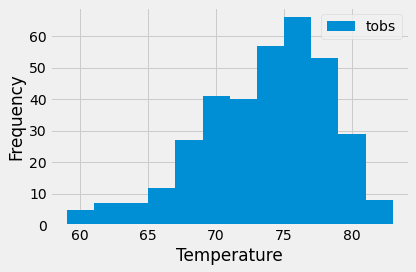

In [33]:
last_12_mths_tobs_df.plot.hist(bins=12)

plt.xlabel("Temperature")

# Save and display the plot
plt.tight_layout()
plt.savefig("Images/station-histogram.png")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
